# **CSCI E-108**
## Professor: Stephen Elston
## Semester: Spring 2024
---

## Food.com Recipe Recommender System Analysis
## by Yuvraj Puri
---

**Background and Introduction**:

The driving force behind this project is the acknowledgement that the frequency of home-cooking for peoples of the United States has, after a period of increase during the Covid-19 pandemic, largely dropped to levels seen prior to this global crisis. In acknowledging this, we must recognize that one of the largest sources of burden for people seeking to prepare and eat their own food is price. Prices for food have gone up globally for any number of causes not limited to inflation, draught, changes in labor costs, import tariffs, and other external factors. A survey out of Purdue University’s Center for Food Demand Analysis conducted between 2022 and March of 2024 observed a peak inflation in food prices of 11.3% in 2022. Despite inflation having decreased significantly to about 2.6% in March of 2024, the fact remains that food price inflation remains a net positive – to say the least of other factors affecting food prices (Koppes).




A Gallup poll also reported the number of meals cooked and eaten at home per week in North America in 2022 appears to have been the lowest globally – approximately 8.4 home-cooked meals per week (Figure 4). This is following a decrease of about 0.7 meals cooked at home and a decrease of about 0.5 meals eaten at home from 2021 to 2022 (Gallup and Cookpad). These levels are similar to levels from prior to the pandemic.
    
Though the reduction in frequency of home-cooking meals may be attributable to the pandemic, it is important to also note that despite all this, there still are many meal-kit providers, grocery delivery services, and online recipe databases. The accessibility to delicious home-cooked meals has never been higher. In that sense, satisfaction from a home-cooked meal will depend preparing the right dish and right recipe for the person eating. In addition, given how satisfaction with food may be intrinsically linked to the cost paid for one’s meal, a starting point would be making sure they have received well-selected meal. To best address both concerns, a recommender system is a solid solution to ensure receive delicious but also cost-affordable home-cooked meals.


**Executive Summary and Conclusions**: The project met one of its original objectives to implement learnt big data analysis and exploration techniques to firstly get useful information from a dataset and secondly to test a range of algorithms as recommendation systems.

The EDA part allowed us to learn a few interesting facts about the behavior of thFood.comiusersrs. They tend to provide average or above average ratingswith over 50% of those being 5s.5 in the 0-5 scaleSome users are extremely engaged with the site as they provide far beyond the average users number of reviews70There also seems to be a relatively symmetric distribution of number of ingredients per recipe on the site and number of steps for each recipe. When we analyzed the text of the processed reviews, we found that some users were rating recipes in spite of stating they did not wish to - perhaps a bug from the site.  

The SVD model turned out to be the best recommendation model of the ones from the Surprise package, partly because the collaborative filtering model using K means failed to run due to computational intensity of the calculations. SVD possessed the lowest RMSE and MAE

The project still has some room for improvement. Firstly, the data analysis could be expanded and approached from more angles, especially if more data was added. For example, more movie characteristics such as data on the director, cast and others could make the content-based model more robust. Similarly, more user-generated data, probably from services they interact with more often than with TMDB, could boost the performance of the collaborative model. Secondly, the lack of sufficient RAM memory was a major blocker. It prevented some algorithms from running at all. Hence, the designed methods could be further optimized to allow for better performance and consequently more in-depth analysis.l.

**Objectives**:

The steps we took are as follows: 
* 1 - **Obtain and preprocess the data**. The data can be found on [Kaggle under the Food.com Recipe and Interactions](https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions) title. One of the biggest reasons for selecting this dataset was because a lot of the data had already been preprocessed, training and testing splits had already been prepared. This takes care of a bulk of the preprocessing work. However, the raw data and the ingredient mapping is still useful for Exploratory Data Analaysis and needs processing.  
* 2 - **Exploratory Data Analysis**. We conducted univariate analysis of the data and found values such as mean, median and mode for features. Along with this, we also found and explored additional features for future consideration. We derived this information from all forms of the raw and preprocessed data - for the recipes and interactions.
* 3 - **Model Training and Testing - Surprise**. We chose the Surprise library for recommender system experimentation and relatively easy compatability with our data. We also compared it to a model made on Google Colaboratory.
* 4 - **Model Training and Testing - Keras**. We chose to develop a collaborative filtering model in Keras and trained and tested it on Google Colaboratory. This model was based on a prior model developed by Bannerjee in 2020 using the MovieLens dataset.
* 5 - **Results, Summary, and Conclusions**.  

### 1/ Obtain and Preprocess Data

In [15]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
# Holding data, plotting results

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import time
# Sentiment analysis tools

# Surprise package: testing SVD, K Means, and Baseline.
from surprise.prediction_algorithms.matrix_factorization import SVD, NMF
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import Dataset, NormalPredictor, Reader
from surprise import accuracy

# Not importing crossvalidate or train-test-split as we already have separate
# training, validation, and testing files. 

import seaborn as sns

sia= SentimentIntensityAnalyzer() # Instantiate sentiment analyzer

%matplotlib inline

In [106]:
# conda install -c conda-forge scikit-surprise
# Commented out - needed for installation of scikit-surprise.

# Commented out - needed for implementation of calculating sentiment scores
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')


In [88]:
def showdf(df):
    shape = df.shape
    display(shape[0], shape[1])
    display(df.head(5))
    display(df.dtypes)
    
    """Provide basic overview of loaded df.
      Includes shape, datatypes and displaying first 5 rows
      :param df input: pandas dataframe containing loaded data.
    """

def threshold(list, percent):
    """Calculate the threshold for data as an integer.
    param input: list (list or array) containing numerical data
    param percent: int 0-100 containing the percentile of data
    to limit the data to.
    """
    return int(np.percentile(list, percent))

def preprocess_review(review):
    
    """
    Preprocessing: clean and standardize review text data 
    before using it for further analysis or modeling.
    param review: str - contains text of review from dataset.
    """
    
    # Bring all text to lower case
    text = review.lower()
    # Tokenization
    tokens = word_tokenize(text)
    
    # Removing punctuation
    table = str.maketrans('', '', string.punctuation)
    tokens = [word.translate(table) for word in tokens]
    
    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Join the tokens back into text
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

def analyze_sentiment(review_text):
    """
    Analyzes the sentiment of the preprocessed review (review_text)
    
    Provides compound_score: the compound sentiment score
    """
    # Analyze sentiment
    sentiment_scores = sia.polarity_scores(review_text)
    
    # Extract the compound sentiment score
    compound_score = sentiment_scores['compound']
    
    return compound_score

In [3]:
PP_recipes = 'C:/Users/Yuvraj/Downloads/archive/PP_recipes.csv'
menu = pd.read_csv(PP_recipes)
# menu: dataframe with the Preprocessed recipe data

PP_users = 'C:/Users/Yuvraj/Downloads/archive/PP_users.csv'
customers= pd.read_csv(PP_users)
# customers: dataframe with Preprocessed user information

RAW_interactions = 'C:/Users/Yuvraj/Downloads/archive/RAW_interactions.csv'
interact = pd.read_csv(RAW_interactions)
# interact: dataframe with raw user data

RAW_recipes = 'C:/Users/Yuvraj/Downloads/archive/RAW_recipes.csv'
rawcipe = pd.read_csv(RAW_recipes)
# rawcipe: dataframe with raw recipe data

In [35]:
# Showing the information about the RAW recipe dataset
showdf(rawcipe)

231637

12

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

---
The 'rawcipe' dataframe contains the raw recipe data. There are 231637 recipe entries provided here. Each one has a unique recipe identifier (id), their own steps, and other attributes, including number of steps and number of ingredients as well as nutritional value. For this exploration of the recipe data, our focus was on details like the steps taken and the ingredients involved.

---

In [36]:
# Showing the information about the RAW interactions dataset
showdf(interact)

1132367

5

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object

---
The 'interact' dataframe contains over 1 million user interaction entries. Mapped to each user for the specific recipes they reviewed (noted by recipe_id - id in 'rawcipe'), they include the dates these reviews were done, the rating given and the review written for them. For this exploration of the data, our focus was on details such as the reviews and the sentiment behind them along with the numbers of reviews written by the users.

---

In [53]:
# Showing the preprocessed menu dataset
showdf(menu)

178265

8

,id,i,name_tokens,ingredient_tokens,steps_tokens,techniques,calorie_level,ingredient_ids
0,424415,23,"[40480, 37229, 2911, 1019, 249, 6878, 6878, 28...","[[2911, 1019, 249, 6878], [1353], [6953], [153...","[40480, 40482, 21662, 481, 6878, 500, 246, 161...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
1,146223,96900,"[40480, 18376, 7056, 246, 1531, 2032, 40481]","[[17918], [25916], [2507, 6444], [8467, 1179],...","[40480, 40482, 729, 2525, 10906, 485, 43, 8393...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
2,312329,120056,"[40480, 21044, 16954, 8294, 556, 10837, 40481]","[[5867, 24176], [1353], [6953], [1301, 11332],...","[40480, 40482, 8240, 481, 24176, 296, 1353, 66...","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
3,74301,168258,"[40480, 10025, 31156, 40481]","[[1270, 1645, 28447], [21601], [27952, 29471, ...","[40480, 40482, 5539, 21601, 1073, 903, 2324, 4...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
4,76272,109030,"[40480, 17841, 252, 782, 2373, 1641, 2373, 252...","[[1430, 11434], [1430, 17027], [1615, 23, 695,...","[40480, 40482, 14046, 1430, 11434, 488, 17027,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"


id                    int64
i                     int64
name_tokens          object
ingredient_tokens    object
steps_tokens         object
techniques           object
calorie_level         int64
ingredient_ids       object
dtype: object

---
The 'menu' dataframe contains the preprocessed recipe data. We can see that there are 178625 entries for unique recipe identifiers. 'id' refers to the recipe id whereas 'i' refers to the contiguous id that is mapped to a recipe from 0 to the total number of recipes in this dataset. The prior preprocessing of the data includes measures such as tokenizing the recipe text and recipe tag metadata via a GPT subword tokenizer. 

---

In [55]:
# Showing the preprocessed interaction dataset
showdf(customers)

25076

6

,u,techniques,items,n_items,ratings,n_ratings
0,0,"[8, 0, 0, 5, 6, 0, 0, 1, 0, 9, 1, 0, 0, 0, 1, ...","[1118, 27680, 32541, 137353, 16428, 28815, 658...",31,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0, ...",31
1,1,"[11, 0, 0, 2, 12, 0, 0, 0, 0, 14, 5, 0, 0, 0, ...","[122140, 77036, 156817, 76957, 68818, 155600, ...",39,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",39
2,2,"[13, 0, 0, 7, 5, 0, 1, 2, 1, 11, 0, 1, 0, 0, 1...","[168054, 87218, 35731, 1, 20475, 9039, 124834,...",27,"[3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, ...",27
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
4,4,"[161, 1, 1, 86, 93, 0, 0, 11, 2, 141, 0, 16, 0...","[72857, 38652, 160427, 55772, 119999, 141777, ...",376,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 4.0, 5.0, ...",376


u              int64
techniques    object
items         object
n_items        int64
ratings       object
n_ratings      int64
dtype: object

---
The 'customers' dataframe contains the preprocessed interaction data of the users - of which there are approximately 25076. The column 'u' refers to the user's id after being mapped to a continguous integer between 0 and the number of users. The 'techniques' column refers to cooking techniques encountered by the user while 'items' refers to the recipes interacted with in order. The 'n_items' column refers to the number of recipes reviewed while the 'n_ratings' column refers to the number of ratings given by this particular user. Of particular interest for analysis are the order in which items are interacted with, the ratings given, and the number of ratings and reviews conducted. 

---

##### 0 Score Ratings

A dataset undergoes processing to filter out issues like error or outliers. One type of data we came across during our analysis was instances of ratings with 0 score whose reviews contained language that was very positive (did not reflect the score given) or language that stated that the individual rating was "not going to rate" only to have a 0 star rating included. Ultimately, this reflects the error of both the users utilizing the service and the review/rating system that took their data.

In conferring how to handle this data for our exploratory analysis, we decided to make the decision to keep the reviews with positive language while also deciding to remove entries from 'interact' that had the language suggesting the user did not wish to rate the dish.

To do so, we investigated the data of the 0 score ratings from interact.

---

In [91]:
# Zero_int - found by filtering for only the instances where the rating was 0.
zero_int = interact[interact['rating'] == 0]

# We preprocess the review and make a new column for the processed review text 
# to find key words
# We calculate the compound sentiment in the review and make a column for it
zero_int['nltk'] = zero_int['review'].apply(preprocess_review)
zero_int['sentiment'] = zero_int['nltk'].apply(analyze_sentiment)
showdf(zero_int)

C:\Users\Yuvraj\AppData\Local\Temp\ipykernel_26732\2727825584.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_int['nltk'] = zero_int['review'].apply(preprocess_review)
C:\Users\Yuvraj\AppData\Local\Temp\ipykernel_26732\2727825584.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zero_int['sentiment'] = zero_int['nltk'].apply(analyze_sentiment)


60847

7

,user_id,recipe_id,date,rating,review,nltk,sentiment
6,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo...",observation rate followed procedure strawber...,0.6705
12,468945,134728,2008-02-20,0,Made my own buttermilk w/ vinegar and milk. U...,made buttermilk w vinegar milk used defrosted...,0.4939
23,681408,225241,2008-03-14,0,This is a very good recipe. We also want to c...,good recipe also want cut back fat content di...,0.2732
39,2002068522,29093,2018-03-26,0,i made it and it was amazing,made amazing,0.5859
56,980899,79222,2010-10-18,0,"I used half cream and half 1% milk, added anot...",used half cream half 1 milk added another 12...,0.5709


user_id        int64
recipe_id      int64
date          object
rating         int64
review        object
nltk          object
sentiment    float64
dtype: object

---
We have found that in the 'interact' dataframe, there are 60847 entries with rating scores of 0. Of note, we see in the first entry, a review where the person states they will not rate the dish and, in the section containing the preprocessed text, the word 'rate'. 

One other detail of note is that 'sentiment' - the compound score portion of the polarity scores - does not perfectly reflect the sentiment one may detect in the review. This is because 

In [87]:
# rate_zero: a slice of the zero_int dataframe where all the preprocessed texts
# contain specific instances of the word 'rate'
rate_zero = zero_int[zero_int['nltk'].str.contains(r'\brate\b', regex=True)]

In [83]:
showdf(rate_zero)

1440

7

,user_id,recipe_id,date,rating,review,nltk,sentiment
6,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo...",observation rate followed procedure strawber...,0.6705
56,980899,79222,2010-10-18,0,"I used half cream and half 1% milk, added anot...",used half cream half 1 milk added another 12...,0.5709
1132,411045,239952,2010-11-05,0,"I am not going to rate this, since I had to ma...",going rate since make quite change delicious...,0.8742
3748,522099,297846,2008-06-02,0,I dont' want to rate this one because I think ...,dont want rate one think ground turkey used m...,0.9243
5739,125458,161160,2007-03-29,0,"Not sure how to rate this, since given the oth...",sure rate since given two review think must d...,-0.6344


user_id        int64
recipe_id      int64
date          object
rating         int64
review        object
nltk          object
sentiment    float64
dtype: object

We see here that we have successfully found approximately 1440 instances that contain the preprocessed word rate. Looking below, there are a list of the full reviews and texts of the preprocessed reviews. A majority of the instances in these contain language stating the user will not rate the recipe - so they will be removed from interact prior to further processing. There may be instances where such language may or may not be present - e.g. a user stating they want to rate this with an arbitrary, alternative number of stars which may be parsed out. However, given how large 'interact' is (> 1 million entries), removing this much should not significantly impact our analysis. 

In [84]:
# List of full Reviews 
list(rate_zero.review[0:10])

['Just an observation, so I will not rate.  I followed this procedure with strawberries instead of raspberries.  Perhaps this is the reason it did not work well.  Sorry to report that the strawberries I did in August were moldy in October.  They were stored in my downstairs fridge, which is very cold and infrequently opened.  Delicious and fresh-tasting prior to that, though.  So, keep a sharp eye on them.  Personally I would not keep them longer than a month.  This recipe also appears as #120345 posted in July 2009, which is when I tried it.  I also own the Edna Lewis cookbook in which this appears.',
 'I used half cream and half 1% milk, added another 1/2c cream at the end. Was without nutmeg. Added nearly a whole pkg of bacon and two 6 oz cans of crab. I will come back to rate this after I make it again using all the posted ingredients. Really yummy, I need to add the nutmeg and see what that does to the flavor.',
 'I am not going to rate this, since I had to make quite a few change

In [85]:
# List of the processed reviews
list(rate_zero.nltk[0:10])

['observation  rate  followed procedure strawberry instead raspberry  perhaps reason work well  sorry report strawberry august moldy october  stored downstairs fridge  cold infrequently opened  delicious freshtasting prior  though   keep sharp eye  personally would keep longer month  recipe also appears  120345 posted july 2009  tried  also edna lewis cookbook appears ',
 'used half cream half 1  milk  added another 12c cream end  without nutmeg  added nearly whole pkg bacon two 6 oz can crab  come back rate make using posted ingredient  really yummy  need add nutmeg see flavor ',
 'going rate  since make quite change  delicious  first used ground chorizo  since  garlic clove  used garlic powder  used undrained diced tomato place red wine  used beef broth  good made change  even 2 yo really liked  make  maybe able make way written ',
 'dont  want rate one think ground turkey used may contibuted u caring  taste pretty good  texture nt good  think ground turley   ground  patty fell apart

In [ ]:
# Filtering out rate_zero's entries by index
rz_idx = rate_zero.index.tolist()

# Dropping the rate_zero entries
interact.drop(rz_idx, inplace = True)

In [105]:
# Resetting index
interact.reset_index(drop=True, inplace = True)

In [114]:
showdf(interact)

1130927

5

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object

---
The next step will be to drop any NaN values and then process the text of the reviews and obtain compound sentiment scores for each review in the interact dataset. Following which, if there are any rows without a sentiment score or NaN, the row will be dropped to prevent errors while running calculations.

The entire process will take some time.

---

In [116]:
interact.dropna(inplace=True)
interact.reset_index(drop=True, inplace=True)

In [118]:
showdf(interact)
# We dropped all currently present rows with NaN values - a little under 200 rows.

1130758

5

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...
3,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
4,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."


user_id       int64
recipe_id     int64
date         object
rating        int64
review       object
dtype: object

In [119]:
# We will be adding two new columns to interact - nltk and sentiment
# nltk - standardized text derived from the user review
# sentiment - compound polarity score derived from preprocessed review

# Calculating time taken to run preprocess_review and analyze_sentiment
start_time = time.time()
interact['nltk']= interact['review'].apply(preprocess_review)
interact['sentiment'] = interact['nltk'].apply(analyze_sentiment)
end_time = time.time()
execution = end_time - start_time
print("Time taken: {:.6f} seconds".format(execution))

Time taken: 751.169378 seconds


In [123]:
print(interact.shape)
interact.dropna(inplace=True)
interact.reset_index(drop=True, inplace=True)
print(interact.shape)

# There has been no change in the shape. We can move on to EDA.

(1130758, 7)
(1130758, 7)


Of the identified data of interest, the content/generated features to be explored in the EDA will be:
* Ingredients (n_ingredients)
* Reviews (n_items, sentiment)
* Rating (rating, ratings)
* Steps (n_steps)
* Calorie level (calorie_level)

We may also need to consider some details in the context of this being a recipe website - who exactly is reviewing these recipes? What is normal behavior for evaluating Food.com recipes?

### 2/ Exploratory Data Analysis

#### Ingredients (n_ingredients)

In [189]:
def recipe_histo(series, name, title, ylab='Recipe', color='green'):
    """
    Provide histogram and univariate variables from series.
    Includes shape, datatypes and displaying first 5 rows
    :param series input: series or column from dataframe.
    :param name input: str with name used for graph and univariate analysis
    :param color input: str. color for histogram, default green.
    :param ylab input: str. for title. default 'Recipe'
    """
    histo = series
    if max(histo) < 2 and min(histo) > -2:
        plt.hist(histo, bins=40, edgecolor='white', color = color)
    else:
        plt.hist(histo, bins=range(2, max(histo) + 2), edgecolor='white', color = color)
    plt.xlabel(f'Number of {name}')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()
    print(f"Mean number of {name}: {histo.mean()}")
    print(f"Median number of {name}: {histo.median()}")
    print(f"Mode number of {name}: {histo.mode().iloc[0]}")
    print(f"Min number of {name}: {histo.min()}")
    print(f"Max number of {name}: {histo.max()}")

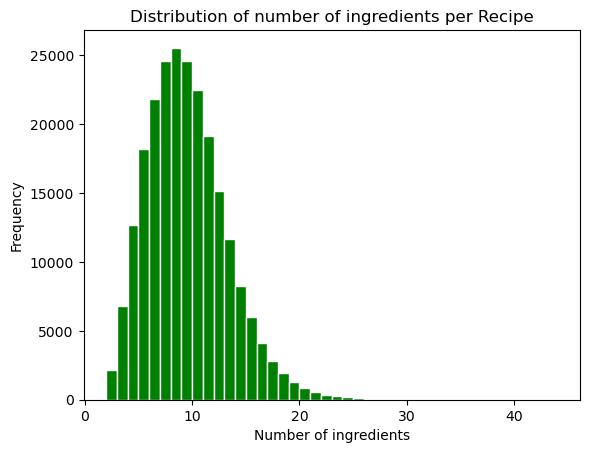

Mean number of ingredients: 9.051153313158087
Median number of ingredients: 9.0
Mode number of ingredients: 8
Min number of ingredients: 1
Max number of ingredients: 43


In [183]:
recipe_histo(rawcipe['n_ingredients'], "ingredients", "Distribution of number of ingredients per Recipe")

The distribution of number of ingredients per recipe is right skewed. The recipes on Food.com use, on average, 9 ingredients per recipe, which is also about the same as the median number of ingredients per recipe. One may assume that recipes with more ingredients may be less used or less popular due to the additional financial strain from purchasing additional ingredients. There may also be recipes that utilize ingredients that require the usage of other ingredients that affect this quantity (e.g. baking recipes requiring at leat eggs, baking powder, milk, etc.) In further investigations, we'd like to check this assumption by adding a variable for price per recipe but due to computational constraints, we did not do so at this time.

#### Reviews (n_items)

We need to consider review quantity from users. The data may require additional consideration if they came from food critics (not average or usual users) or if some reviews came from bots (invalid reviews). To begin with, we will examine the distribution of the quantity of user ratings - that is, how many users have a certain number of ratings. 

In customers, we have seen at least one user has over 1000 ratings given for recipes. Therefore, we will examine the distributions with and without thresholds on the number of reviews.

In [5]:
number_ratings = np.array(customers['n_items'])
percentile_list = [90, 95, 99]


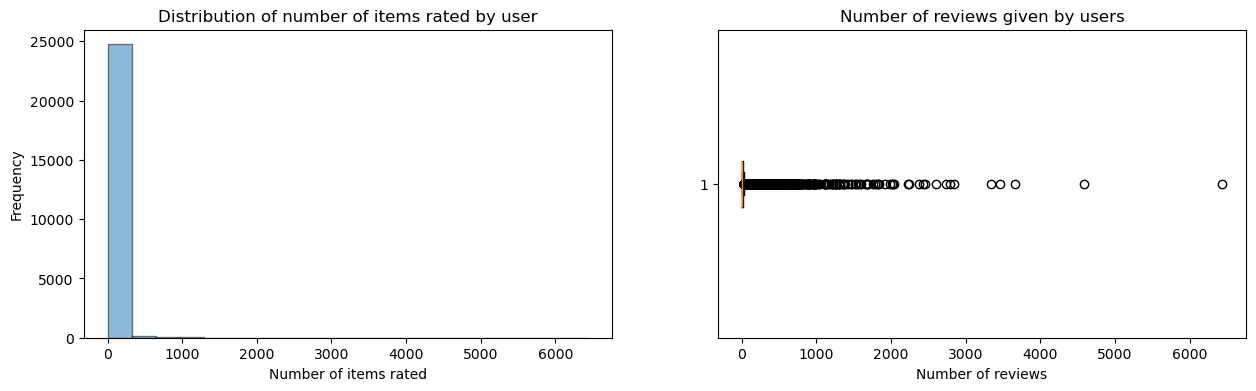

In [7]:
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(number_ratings, bins=20, alpha=0.5, edgecolor="black")  # Exclude outliers
_=ax[0].set_xlabel('Number of items rated')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title(f'Distribution of number of items rated by user')

_=ax[1].boxplot(number_ratings, vert=False)  # Only outliers
_=ax[1].set_xlabel('Number of reviews')
_=ax[1].set_title(f'Number of reviews given by users')

We can see that there's an incredible left skew in the distribution. Upon examination of the boxplot, we see that some users have given reviews in the thousands with the highest at over 6000 reviews. To help identify what may be average user utilization, we will examine these same distributions after removing users above thresholds for number of ratings. These thresholds will be in the 90, 95, and 99 percentiles - the range in which these percentages of the userbase review recipes. 

Threshold of 90% = 45
Number of reviewers above threshold: 2483

Threshold of 95% = 92
Number of reviewers above threshold: 1249

Threshold of 99% = 398
Number of reviewers above threshold: 251



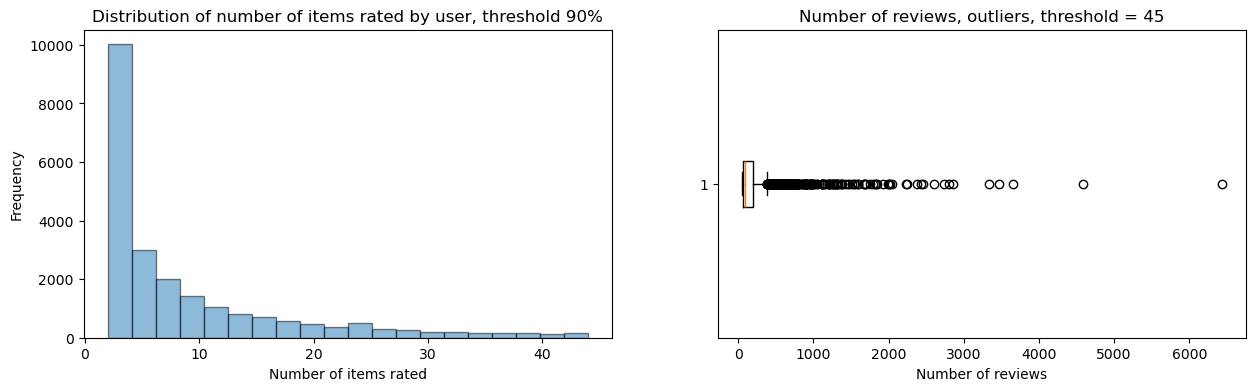

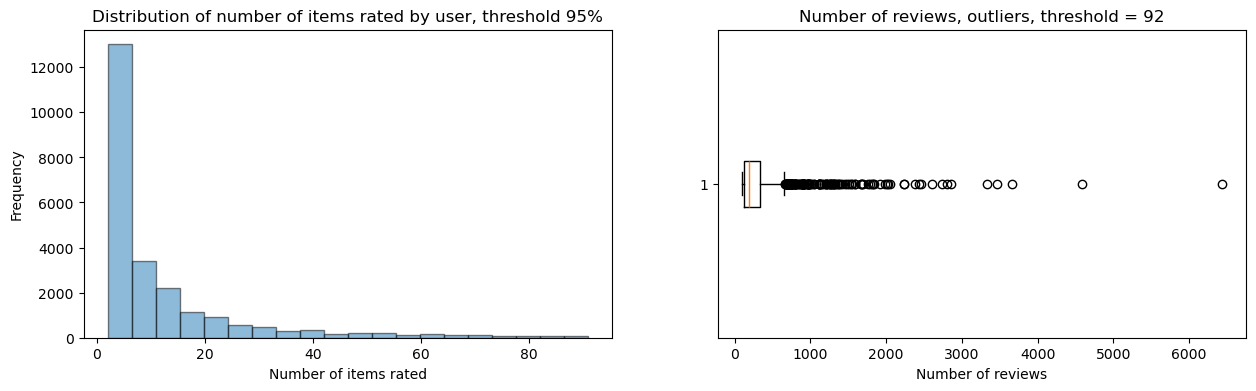

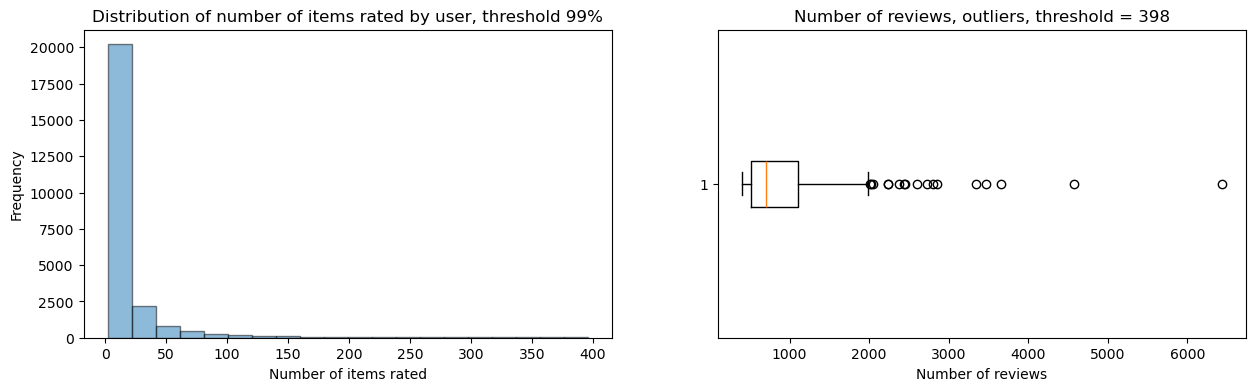

In [176]:
for val in percentile_list:
    thresh = threshold(number_ratings, val)
    print(f"Threshold of {val}% = {thresh}")
    fig,ax= plt.subplots(1,2,figsize=(15,4))
    _=ax[0].hist(number_ratings[number_ratings < thresh], bins=20, alpha=0.5, edgecolor="black")  # Exclude outliers
    _=ax[0].set_xlabel('Number of items rated')
    _=ax[0].set_ylabel('Frequency')
    _=ax[0].set_title(f'Distribution of number of items rated by user, threshold {val}%')

    _=ax[1].boxplot(number_ratings[number_ratings > thresh], vert=False)  # Only outliers
    _=ax[1].set_xlabel('Number of reviews')
    _=ax[1].set_title(f'Number of reviews, outliers, threshold = {thresh}')
    total_rev = len(number_ratings)
    n_above = len(number_ratings[number_ratings>thresh])
    print(f"Number of reviewers above threshold: {n_above}\n")

Keeping track of the changes, we saw that the distribution became less skewed as the threshold decreased from 99% to 90%. At the same time, these outliers in terms of reviewing were at startlingly different thresholds. The 99% percentile threshold is almost 400 reviews per user whereas the 95% percentile for number of reviews per user is 92 and the 90% percentile is 45. Keeping in mind how different user experiences are and how different the thresholds are, we elected to define users who may be bots or food critics as users above the 99th percentile for review quantity per user id and saved them such that we could determine if it was possible to effectively train and test a model while excluding them.

In [212]:
threshold99 = customers[customers['n_items'] > threshold(number_ratings, 99)]
# Keeping track of the 99% threshold and above customers. 
# Will be utilized for filtering for training purposes.
showdf(threshold99)

251

6

,u,techniques,items,n_items,ratings,n_ratings
3,3,"[498, 13, 4, 218, 376, 3, 2, 33, 16, 591, 10, ...","[163193, 156352, 102888, 19914, 169438, 55772,...",1513,"[5.0, 5.0, 5.0, 5.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...",1513
10,10,"[196, 8, 3, 78, 190, 3, 3, 20, 3, 243, 24, 27,...","[50183, 55596, 168324, 165343, 147615, 98452, ...",748,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, ...",748
17,17,"[554, 10, 4, 183, 327, 3, 1, 92, 7, 525, 21, 3...","[135455, 8026, 119308, 139100, 62293, 101473, ...",1592,"[5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, ...",1592
19,19,"[167, 10, 1, 74, 128, 0, 1, 16, 4, 195, 5, 15,...","[119019, 167743, 152998, 145979, 81377, 127080...",528,"[4.0, 4.0, 4.0, 4.0, 5.0, 4.0, 5.0, 4.0, 4.0, ...",528
20,20,"[236, 4, 1, 61, 100, 0, 0, 31, 3, 191, 15, 16,...","[48405, 19903, 109284, 157594, 169430, 137882,...",641,"[4.0, 5.0, 4.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, ...",641


u              int64
techniques    object
items         object
n_items        int64
ratings       object
n_ratings      int64
dtype: object

#### Reviews (sentiment)

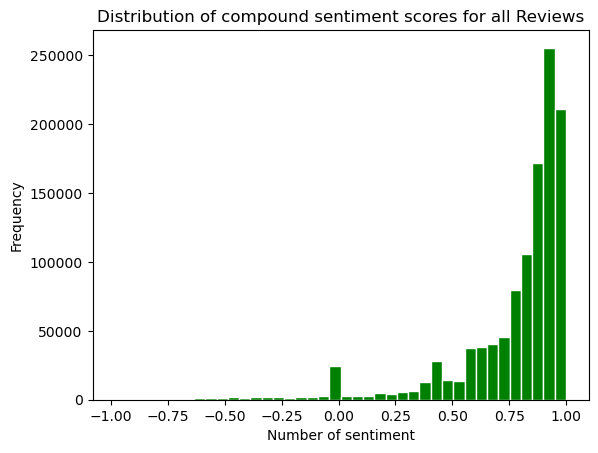

Mean number of sentiment: 0.774531065975213
Median number of sentiment: 0.875
Mode number of sentiment: 0.0
Min number of sentiment: -0.9821
Max number of sentiment: 0.9996


In [193]:
recipe_histo(interact['sentiment'], "sentiment", "Distribution of compound sentiment scores for all Reviews")

In [245]:
def sent_pie(series):
    temp = np.array(series)
    counts = {
    '=0.0': sum(1 for value in temp if value == 0.0),
    '>0.0': sum(1 for value in temp if value > 0),
    '<0.0': sum(1 for value in temp if value < 0)
    }
    labels = counts.keys()
    sizes = counts.values()
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Percentages of Sentiment Scores')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    for i, (label, count) in enumerate(counts.items()):
        plt.annotate(f'{label}: {count}', xy=(0, 0), xytext=(-1.5, 1 - i * 0.5), fontsize=10, color='black')

    plt.show()
     

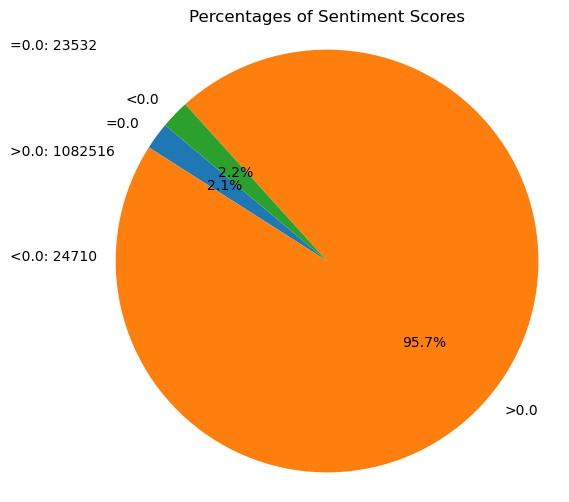

In [236]:
sent_pie(interact['sentiment'])

Sentiment was a feature generated by preprocessing the text of reviews and obtaining the compound sentiment score. Due to how completely skewed the percentage of sentiment appears to be, compound sentiment scores generated from the nltk library do not seem going to be an feature that may accurately understand the data in the context of this rating metric. With that said, this may also reflect that the majority of users do have something positive to say about the recipes themselves. It may also suggest inherent inaccuracy with the compound sentiment score calculations. 

Ultimately, we chose to elect to adjust our recommendation of utilizing sentiment for recommender systems. Further testing and adjustment is recommended due to current constraints.

#### Ratings (rating) - from 'interact'

rat_pie: a method to display a piechart of the ratings for a given series.

In [9]:
def rat_pie(series):
    temp = np.array(series)
    counts = {
    '0': sum(1 for value in temp if ((value == 0.0))),
    '1': sum(1 for value in temp if ((value == 1.0))),
    '2': sum(1 for value in temp if ((value == 2.0))),
    '3': sum(1 for value in temp if ((value == 3.0))),
    '4': sum(1 for value in temp if ((value == 4.0))),
    '5': sum(1 for value in temp if ((value ==5.0)))
    }
    labels = counts.keys()
    sizes = counts.values()
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Percentage of ratings by score interval')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    for i, (label, count) in enumerate(counts.items()):
        print(f'{label}: {count}')
    plt.show()

0: 60847
1: 12818
2: 14123
3: 40855
4: 187360
5: 816364


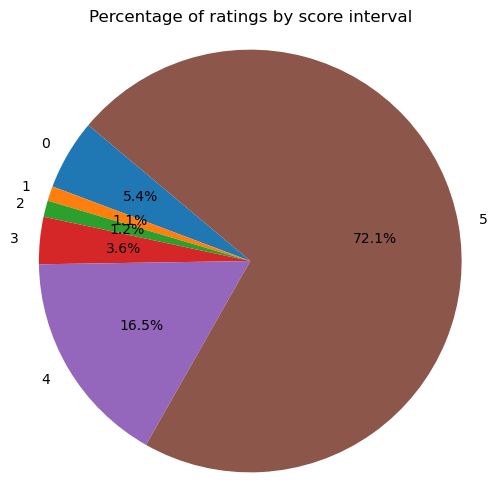

In [10]:
# Finding the number of individual ratings within the intervals specified
# within interact
rat_pie(interact['rating'])

We can see that the majority of the ratings seem to be overwhelmingly positive - a 5 star rating.

In [11]:
# mean_hist: return a list of the mean ratings for each user
def mean_hist(series):
    temp = series
    means = []
    for val in temp:
        value = ast.literal_eval(val)
        mean = np.mean(value)
        means.append(mean)
    return means

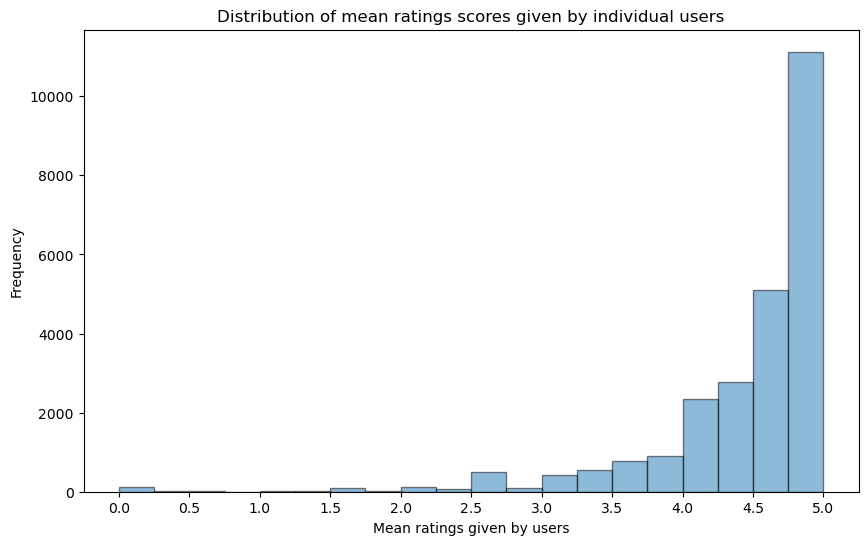

In [310]:
# Finding the distribution of mean review scores given by the individual users
mean_data = mean_hist(customers['ratings'])
fig,ax= plt.subplots(figsize=(10,6))
ticks = np.arange(min(mean_data), max(mean_data) + 0.1, 0.5)
_=ax.hist(mean_data, bins=20, alpha=0.5, edgecolor="black") 
_=ax.set_xticks(ticks)
_=ax.set_xlabel('Mean ratings given by users')
_=ax.set_ylabel('Frequency')
_=ax.set_title('Distribution of mean ratings scores given by individual users')

We elected to utilize ratings as a feature to utilize for recommender systems because of how users interact with them - if a user sees a positive rating on a recipe, they are more likely to not only interact with it but make and even review them as well. It is an important feature for predicting itself and is a primary factor in recommending recipes for users as well as users selecting them.

From the piechart and the histogram, we can see that that mean review score given by users is not only overwhelmingly high but also an overwhelmingly popular choice to do so. Most of the reviewers of the Food.com recipes posses very positive sentiment towards all the recipes they interact with. If we are to utilize the ratings given by customers, some form of normalization will be necessary to train a model to be able to generalize with their recommendations. 

#### Steps (n_steps)

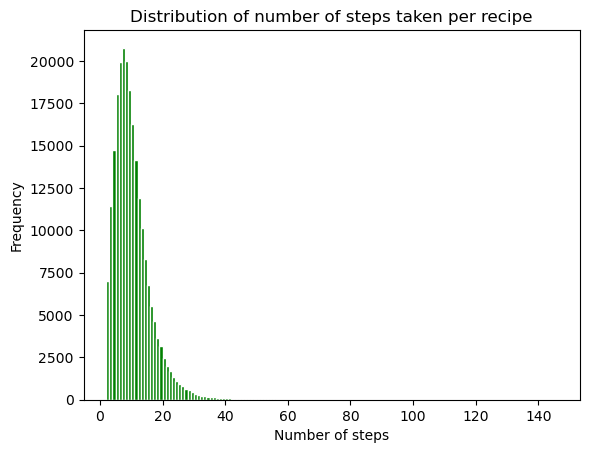

Mean number of steps: 9.7654994668382
Median number of steps: 9.0
Mode number of steps: 7
Min number of steps: 0
Max number of steps: 145


In [238]:
recipe_histo(rawcipe['n_steps'], "steps", "Distribution of number of steps taken per recipe")

The number of steps can be something that will both dissuade and persuade users to utilize specific recipes. Step quantity can indicate to a user that a recipe may be overly complicated or very simple; it can indicate it will take a long preparation time or a short amount of preparation. Hence we elected to evaluate the number of steps in each recipe.

From the following histogram, we detect a rightward skew in terms of the number of steps a recipe has. However, the distribution is fairly normal - the mean and median number of steps are fairly close to one another. it suggests that the data is symmetric or approximately symmetric in terms of the number of steps that a recipe has. However, given the degree of skew (max of 145 vs a mean/median of 9), we may need to threshold the data to obtain data that won't negatively impact training.

Threshold of 90% = 17
Number of recipes above threshold: 5807

Threshold of 95% = 21
Number of recipes above threshold: 4877

Threshold of 99% = 30
Number of recipes above threshold: 3550



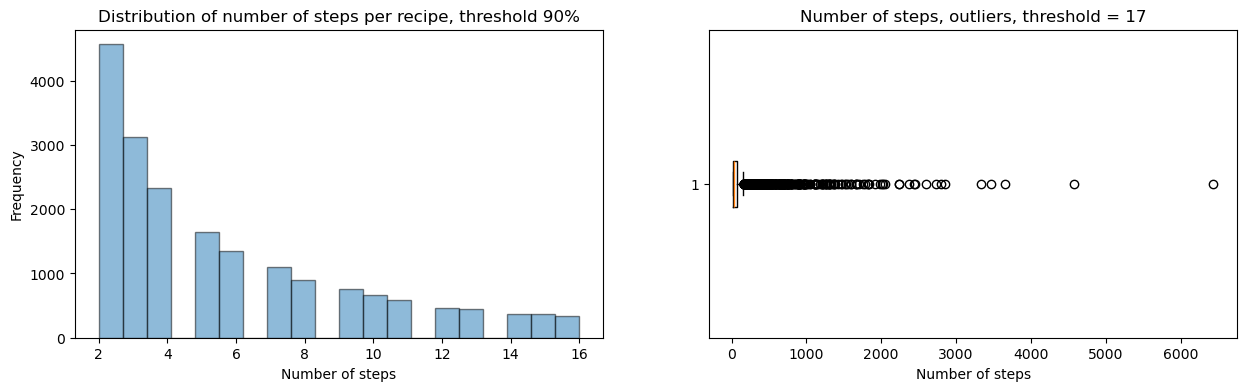

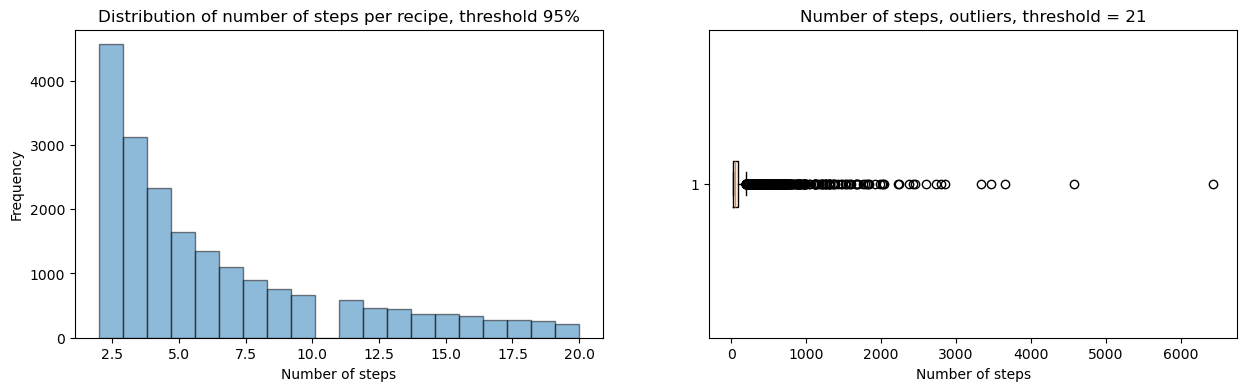

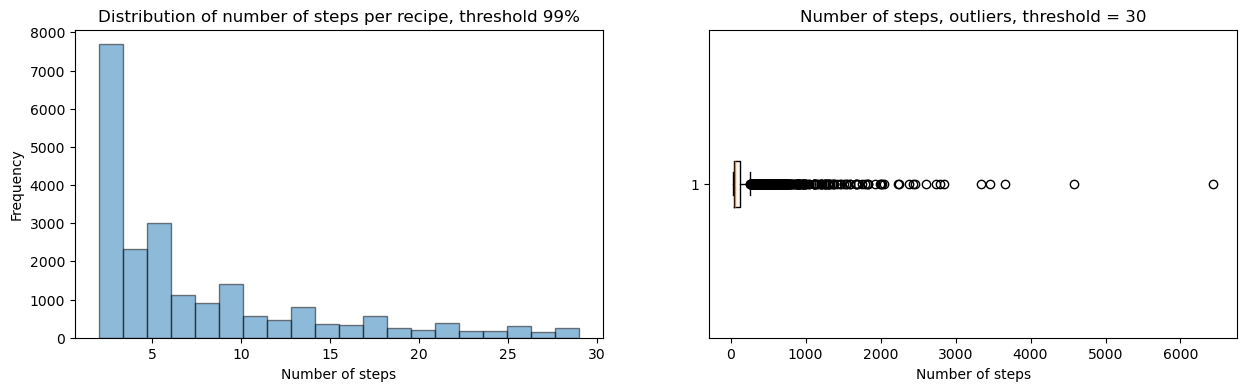

In [14]:
number_steps = np.array(rawcipe['n_steps'])
for val in percentile_list:
    thresh = threshold(number_steps, val)
    print(f"Threshold of {val}% = {thresh}")
    fig,ax= plt.subplots(1,2,figsize=(15,4))
    _=ax[0].hist(number_ratings[number_ratings < thresh], bins=20, alpha=0.5, edgecolor="black")  # Exclude outliers
    _=ax[0].set_xlabel('Number of steps')
    _=ax[0].set_ylabel('Frequency')
    _=ax[0].set_title(f'Distribution of number of steps per recipe, threshold {val}%')

    _=ax[1].boxplot(number_ratings[number_ratings > thresh], vert=False)  # Only outliers
    _=ax[1].set_xlabel('Number of steps')
    _=ax[1].set_title(f'Number of steps, outliers, threshold = {thresh}')
    total_rev = len(number_ratings)
    n_above = len(number_ratings[number_ratings>thresh])
    print(f"Number of recipes above threshold: {n_above}\n")

From the data, it does not appear that there is much need to threshold the data. The number of steps by the threshold doesn't appear to be radically as radically different from the center of the data as the review count was. These outliers may not impede the training of the recommendation model significantly.

#### Calorie level (calorie_level)

In [244]:
def cal_pie(series):
    temp = np.array(series)
    counts = {
    '0': sum(1 for value in temp if value == 0),
    '1': sum(1 for value in temp if value == 1),
    '2': sum(1 for value in temp if value == 2)
    }
    labels = counts.keys()
    sizes = counts.values()
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title('Percentages of Recipes by Calorie Level')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    for i, (label, count) in enumerate(counts.items()):
        plt.annotate(f'{label}: {count}', xy=(0, 0), xytext=(-1.5, 1 - i * 0.5), fontsize=10, color='black')

    plt.show()


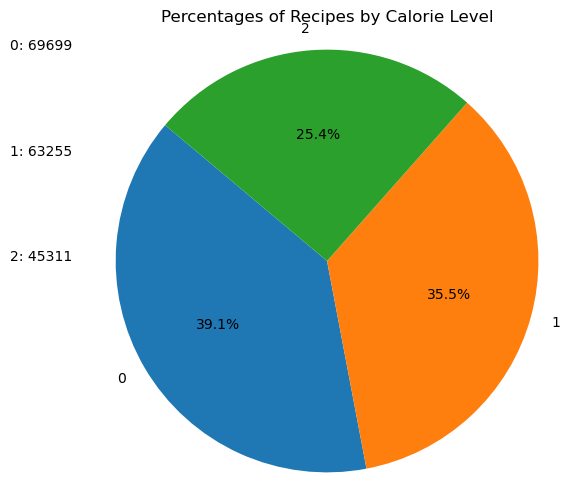

In [246]:
cal_pie(menu['calorie_level'])

In the current health conscious client, most people also elect to decide what foods to make based on calorie count. Keeping that in mind, the calorie count variable refers to a range of calories present (0-999; 1000-1999; 2000+) for 0, 1, and 2. Given the even spread of this variable and its relevance in user-item interaction, we highly recommend utilizing this variable for further analysis though we have elected not to utilize it for our recommender system experimentation today.

---

#### Popularity - from interact

In [344]:
find = interact.groupby('recipe_id').size()
sorted_find = find.sort_values(ascending=False)
top10recipes = sorted_find.head(10)
# Finding the 10 most popular recipes by which has been reviewed the most

top10recipes.name = 'review_count'
best_recipes = rawcipe[rawcipe['id'].isin(top10recipes.index)]
# Merging and showing top 10 recipes sorted by review_count
merged_data = pd.merge(best_recipes, top10recipes, left_on='id', right_index=True, how='inner')
sorted_best = merged_data.sort_values(by='review_count', ascending=False)
sorted_best

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,review_count
22168,best banana bread,2886,65,1762,1999-09-26,"['time-to-make', 'course', 'main-ingredient', ...","[272.8, 16.0, 97.0, 14.0, 7.0, 31.0, 14.0]",13,"['remove odd pots and pans from oven', 'prehea...",you'll never need another banana bread recipe ...,"['butter', 'granulated sugar', 'eggs', 'banana...",8,1608
213826,to die for crock pot roast,27208,545,28201,2002-05-03,"['weeknight', 'time-to-make', 'course', 'main-...","[295.2, 14.0, 0.0, 15.0, 99.0, 19.0, 0.0]",7,"['place beef roast in crock pot', 'mix the dri...","amazing flavor, and so simple! no salt needed ...","['beef roast', 'brown gravy mix', 'dried itali...",5,1599
66687,crock pot chicken with black beans cream cheese,89204,243,137839,2004-04-16,"['time-to-make', 'course', 'main-ingredient', ...","[679.2, 53.0, 39.0, 38.0, 91.0, 75.0, 16.0]",5,"['take 4-5 frozen , yes , frozen , boneless ch...",i love this crock-pot chicken recipe for two r...,"['boneless chicken breasts', 'black beans', 'c...",5,1578
62431,creamy cajun chicken pasta,39087,25,30534,2002-09-02,"['30-minutes-or-less', 'time-to-make', 'course...","[719.1, 63.0, 12.0, 34.0, 78.0, 120.0, 15.0]",4,['place chicken and cajun seasoning in a bowl ...,n'awlin's style of chicken with an updated alf...,"['boneless skinless chicken breast halves', 'l...",12,1448
22388,best ever banana cake with cream cheese frosting,67256,75,82367,2003-07-24,"['weeknight', 'time-to-make', 'course', 'main-...","[503.5, 31.0, 222.0, 15.0, 11.0, 61.0, 25.0]",18,"['preheat oven to 275f', 'grease and flour a 9...",this is one of (if not) the best banana cake i...,"['bananas', 'lemon juice', 'flour', 'baking so...",13,1321
229262,yes virginia there is a great meatloaf,54257,80,24670,2003-02-17,"['time-to-make', 'course', 'main-ingredient', ...","[493.1, 43.0, 75.0, 52.0, 70.0, 55.0, 7.0]",15,['meatloaf: combine meat loaf ingredients and ...,absolutely delicious meatloaf and sauce! those...,"['ground beef', 'bread', 'egg', 'vidalia onion...",10,1304
115303,jo mama s world famous spaghetti,22782,80,25455,2002-03-17,"['weeknight', 'time-to-make', 'course', 'main-...","[555.9, 40.0, 45.0, 85.0, 59.0, 45.0, 16.0]",10,"['in large , heavy stockpot , brown italian sa...",my kids will give up a steak dinner for this s...,"['italian sausage', 'onion', 'garlic cloves', ...",16,1233
574,whatever floats your boat brownies,32204,35,37305,2002-06-25,"['60-minutes-or-less', 'time-to-make', 'course...","[390.7, 30.0, 161.0, 7.0, 12.0, 50.0, 17.0]",14,"['preheat oven to 350f', 'grease an 8 inch squ...","these are absolutely the chewiest, moistest, f...","['butter', 'unsweetened cocoa', 'sugar', 'eggs...",14,1216
118161,kittencal s italian melt in your mouth meatballs,69173,50,89831,2003-08-20,"['60-minutes-or-less', 'time-to-make', 'course...","[1312.6, 129.0, 8.0, 108.0, 214.0, 174.0, 8.0]",5,['mix all ingredients together in a large bowl...,cooking the meatballs in simmering pasta sauce...,"['ground beef', 'egg', 'parmesan cheese', 'bre...",10,997
114444,japanese mum s chicken,68955,45,29196,2003-08-13,"['60-minutes-or-less', 'time-to-make', 'course...","[313.1, 19.0, 54.0, 61.0, 62.0, 17.0, 5.0]",5,['place all the ingredients in a saucepan over...,"we have a japanese girl, tomoko, living with u...","['chicken drumsticks', 'water', 'balsamic vine...",7,903


Knowing that users are more likely to select popular items, which is a consequence of recommendation systems such as Baseline models, we elected to also present the most popular recipes evaluating for review count. The most popular recipe has over 1600 reviews and more than likely many more interactions.

### 3/ Model Training and Testing - Surprise

In [247]:
trainfile = 'C:/Users/Yuvraj/Downloads/archive/interactions_train.csv'
training = pd.read_csv(trainfile)
# training: dataframe with the training data for our recommender models

testfile = 'C:/Users/Yuvraj/Downloads/archive/interactions_test.csv'
testing = pd.read_csv(testfile)
# testing: dataframe with the testing data for our recommender models

validfile = 'C:/Users/Yuvraj/Downloads/archive/interactions_validation.csv'
val = pd.read_csv(validfile)
# val: dataframe with the validation data for our recommender models.

In [345]:
showdf(training)
# Examining the shape and structure of the training, test, and validation datasets

698901

6

,user_id,recipe_id,date,rating,u,i
0,2046,4684,2000-02-25,5.0,22095,44367
1,2046,517,2000-02-25,5.0,22095,87844
2,1773,7435,2000-03-13,5.0,24732,138181
3,1773,278,2000-03-13,4.0,24732,93054
4,2046,3431,2000-04-07,5.0,22095,101723


user_id        int64
recipe_id      int64
date          object
rating       float64
u              int64
i              int64
dtype: object

In [346]:
showdf(testing)

12455

6

,user_id,recipe_id,date,rating,u,i
0,8937,44551,2005-12-23,4.0,2,173538
1,56680,126118,2006-10-07,4.0,16,177847
2,349752,219596,2008-04-12,0.0,26,89896
3,628951,82783,2007-11-13,2.0,45,172637
4,92816,435013,2013-07-31,3.0,52,177935


user_id        int64
recipe_id      int64
date          object
rating       float64
u              int64
i              int64
dtype: object

In [347]:
showdf(val)

7023

6

,user_id,recipe_id,date,rating,u,i
0,76535,33627,2005-02-15,4.0,5,177317
1,160497,75307,2005-10-24,4.0,23,170785
2,930021,100961,2008-11-30,4.0,31,165555
3,58439,154105,2007-03-24,4.0,44,177453
4,628951,14525,2008-02-16,5.0,45,142367


user_id        int64
recipe_id      int64
date          object
rating       float64
u              int64
i              int64
dtype: object

Prior to beginning testing, we will take two steps: we will examine some of how the data is distributed in the training, testing, and validation sets. We will also follow up and filter out some of the data from there that has been deemed worth taking out - specifically, the data from 'rate_zero' of people who don't want to rate the recipes and the people from the 99% threshold who had put out some of the most reviews to help with the distributions.

training
0-1: 16957
1-2: 3341
2-3: 6852
3-4: 25781
4-5: 127402


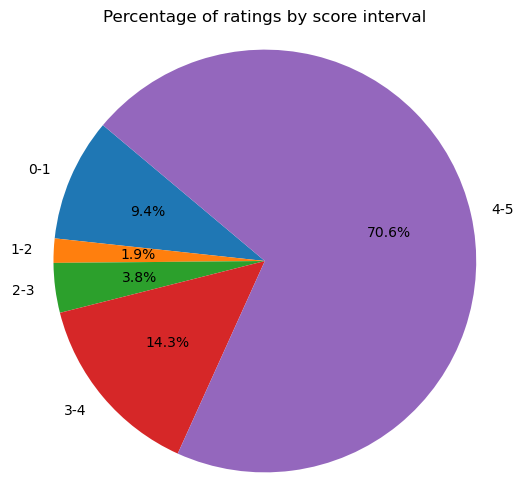

testing
0-1: 687
1-2: 249
2-3: 311
3-4: 815
4-5: 2807


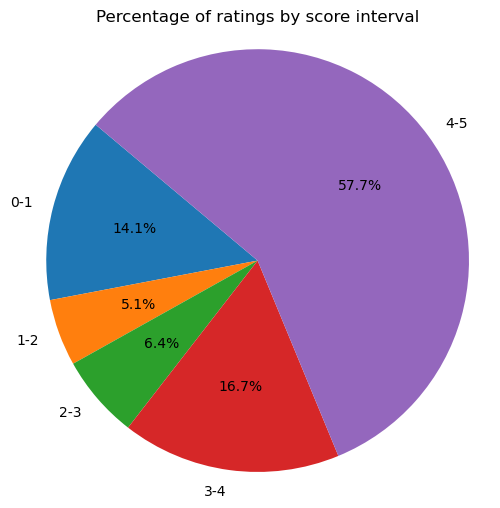

val
0-1: 356
1-2: 132
2-3: 173
3-4: 462
4-5: 1637


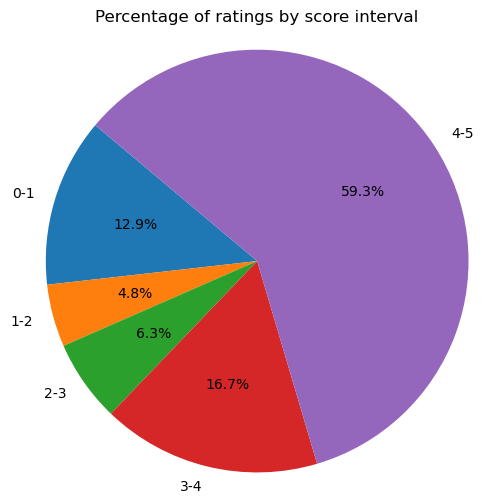

In [353]:
titles = [training, testing, val]
count = 0
string_titles = ["training", "testing", "val"]
for set in titles:
    print(string_titles[count])
    rat_pie(set['rating'])
    count+=1

We see that testing and validation have similar distributions by rating. We also see that the training data set has a greater skew towards scores of 4-5 which may affect our generalizability or our ability to recommend.

In [355]:
rate_zero

,user_id,recipe_id,date,rating,review,nltk,sentiment
6,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo...",observation rate followed procedure strawber...,0.6705
56,980899,79222,2010-10-18,0,"I used half cream and half 1% milk, added anot...",used half cream half 1 milk added another 12...,0.5709
1132,411045,239952,2010-11-05,0,"I am not going to rate this, since I had to ma...",going rate since make quite change delicious...,0.8742
3748,522099,297846,2008-06-02,0,I dont' want to rate this one because I think ...,dont want rate one think ground turkey used m...,0.9243
5739,125458,161160,2007-03-29,0,"Not sure how to rate this, since given the oth...",sure rate since given two review think must d...,-0.6344
...,...,...,...,...,...,...,...
1130102,1027074,137575,2010-05-18,0,I can't rate this fairly but I will give a qui...,ca nt rate fairly give quick recap experience ...,0.9260
1130296,169430,457171,2011-06-22,0,This is kind of hard to rate because it's goin...,kind hard rate going come personal preference ...,0.9694
1130461,141012,38966,2010-06-03,0,I tried this cake recipe today. The only chang...,tried cake recipe today change made use marga...,0.7430
1131751,209137,99731,2007-12-13,0,This recipe unfortunately did not work out for...,recipe unfortunately work made directed mushy...,0.8271


In [369]:
def remove_zeros(df):
    temp_0 = rate_zero[['user_id','recipe_id','date','rating']]
    merged = pd.merge(df, temp_0, on=['user_id','recipe_id','date','rating'], how='left', indicator=True)

    # Filter out rows where there is a match in 'rate_zero'
    filtered = merged[merged['_merge'] == 'left_only']

    # Drop the indicator column
    filtered = filtered.drop(columns='_merge')
    return filtered

In [372]:
def remove_thresh(df):
    temp_t = threshold99[['u']]
    merged = pd.merge(df, temp_t, on=['u'], how='left', indicator=True)

    # Filter out rows where there is a match in 'rate_zero'
    filtered = merged[merged['_merge'] == 'left_only']

    # Drop the indicator column
    filtered = filtered.drop(columns='_merge')
    return filtered

In [375]:
print(remove_thresh(training).shape)

(462433, 6)


We utilized the remove_zeros method to help filter some of the entries out of our training and testing sets. We ultimately did not remove the users with the most reviews because they made up too much of the training data - so while identifying them did bring up interesting data to explore, they also made up too much of the training and testing sets to comfortably alter.

In [383]:
training = remove_zeros(training)
testing = remove_zeros(testing)
val = remove_zeros(val)

Rows: 697924
training
0-1: 15980
1-2: 3341
2-3: 6852
3-4: 25781
4-5: 127402


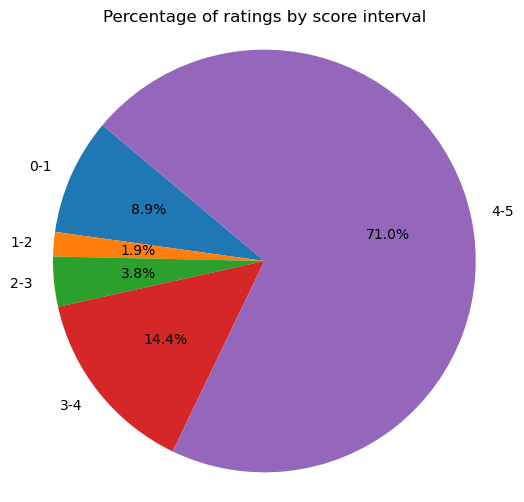

Rows: 12436
testing
0-1: 668
1-2: 249
2-3: 311
3-4: 815
4-5: 2807


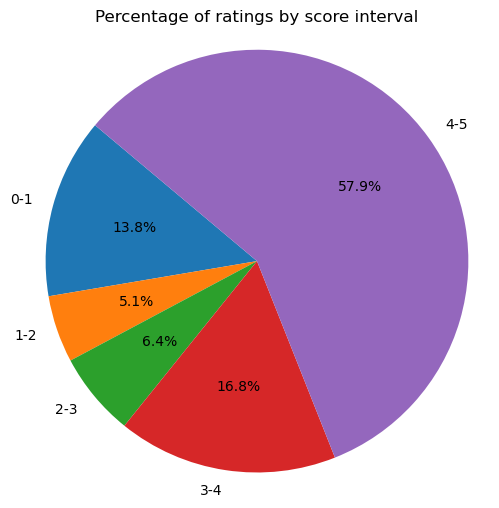

Rows: 7017
val
0-1: 350
1-2: 132
2-3: 173
3-4: 462
4-5: 1637


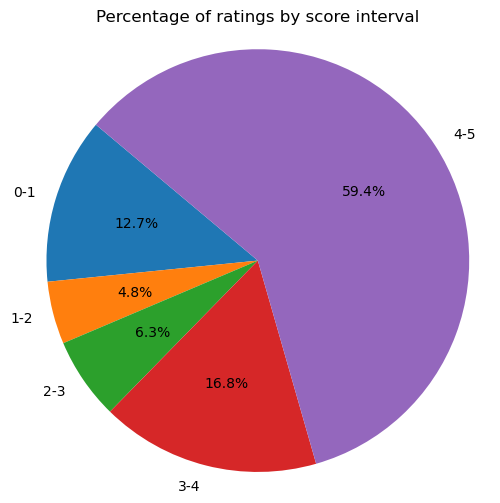

In [387]:
count=0
titles = [training, testing, val]
for set in titles:
    print(f"Rows: {set.shape[0]}")
    print(string_titles[count])
    rat_pie(set['rating'])
    count+=1

We then saved our results to csvs for our colaboratory work.

In [389]:
training.to_csv("C:/Users/Yuvraj/Downloads/archive/new_training.csv", index=False)
testing.to_csv("C:/Users/Yuvraj/Downloads/archive/new_testing.csv", index=False)
val.to_csv("C:/Users/Yuvraj/Downloads/archive/new_val.csv", index=False)

**Beginning of Surprise Model work**

In [ ]:
def remodel(df):
    surprise = df.loc[:, ['recipe_id', 'user_id', 'rating']]
    surprise.rename(columns={'recipe_id': 'itemID', 'user_id': 'userID'}, inplace=True)
    return surprise


To convert the dataframe to Dataset, we needed to remodel the dataframes with these specifications. From there, we could convert the training set into a full training set and the test set (testing) in to a full test set using methods from the Trainset module.

In [405]:
training_surprise = remodel(training)
showdf(training_surprise)

697924

3

,itemID,userID,rating
0,4684,2046,5.0
1,517,2046,5.0
2,7435,1773,5.0
3,278,1773,4.0
4,3431,2046,5.0


itemID      int64
userID      int64
rating    float64
dtype: object

In [427]:
# Creating the full trainset from the training data
reader = Reader(rating_scale=(0, 5))
surprise_dataset = Dataset.load_from_df(training_surprise[["userID", "itemID", "rating"]], reader)
ml_trainset = surprise_dataset.build_full_trainset()
# Using the whole training dataframe as the training dataset                                   

In [425]:
test_surprise = remodel(testing)
showdf(test_surprise)

12436

3

,itemID,userID,rating
0,44551,8937,4.0
1,126118,56680,4.0
2,219596,349752,0.0
3,82783,628951,2.0
4,435013,92816,3.0


itemID      int64
userID      int64
rating    float64
dtype: object

In [426]:
surprise_datatest = Dataset.load_from_df(test_surprise[["userID", "itemID", "rating"]], reader)
ml_testset = surprise_datatest.build_full_trainset()
# Using the whole dataset that is the testing set as the test set
ml_testset = ml_testset.build_testset()

In [397]:
print('For training dataset:')
print("Number of users = {}".format(ml_trainset.n_users))
print("Number of items = {}".format(ml_trainset.n_items))
print("Number of ratings = {}".format(ml_trainset.n_ratings))

For training dataset:
Number of users = 25076
Number of items = 160775
Number of ratings = 697924


In [398]:
print(f"The number of recommendations = {len(ml_trainset.ur[5])}")
ml_trainset.ur[5]

The number of recommendations = 33


[(13, 3.0),
 (14, 5.0),
 (53, 3.0),
 (233, 5.0),
 (815, 4.0),
 (910, 5.0),
 (1413, 5.0),
 (1417, 5.0),
 (2305, 5.0),
 (4857, 4.0),
 (6171, 5.0),
 (16602, 4.0),
 (12423, 5.0),
 (9016, 4.0),
 (12646, 5.0),
 (2888, 5.0),
 (18528, 4.0),
 (23725, 5.0),
 (41051, 5.0),
 (41046, 5.0),
 (13544, 5.0),
 (31388, 4.0),
 (50367, 5.0),
 (29980, 4.0),
 (53174, 5.0),
 (53162, 5.0),
 (56180, 5.0),
 (56138, 5.0),
 (57039, 5.0),
 (17771, 5.0),
 (47193, 5.0),
 (1235, 4.0),
 (71082, 4.0)]

In [423]:
fraction_user5 = len(ml_trainset.ur[5]) / ml_trainset.n_items
print("Number of ratings by user 5 is {}".format(len(ml_trainset.ur[5])))
print(f"Number of total ratings is {ml_trainset.n_items}")
print(f"Fraction of all items rated by user 5 is: {len(ml_trainset.ur[5])} / {ml_trainset.n_items} = {fraction_user5}\n")

total_possible_pairs = ml_trainset.n_users * ml_trainset.n_items
print(f"Total possible pairs: {total_possible_pairs}")
print(f"Number of non-null ratings: {ml_trainset.n_ratings}")
print(f"Fraction of non-null ratings making up the total possible pairs: {ml_trainset.n_ratings} / {total_possible_pairs} = {ml_trainset.n_ratings/total_possible_pairs}")


Number of ratings by user 5 is 33
Number of total ratings is 160775
Fraction of all items rated by user 5 is: 33 / 160775 = 0.00020525579225625875

Total possible pairs: 4031593900
Number of non-null ratings: 697924
Fraction of non-null ratings making up the total possible pairs: 697924 / 4031593900 = 0.00017311366603665117


I think these fractions for an individual and an average user seem about right. Speaking less on programming or statistics, there's an element of randomness as to how much a customer may care enough about a product to rate it. For instance, when it comes to the fraction of all items rated by user 5, there's 33 ratings in total - that user 5 not only purchased 33 items from this item catalog but also took the time to rate them when such inclinations are arbitrary at best to nonexistent given how variable peoples' interests and tastes are is a bit much - unless they're specifically being tasked to help curate or review them. But that puts them outside of the realm of an "average user". At best, I would expect potentially 1-3 ratings from an average user assuming they utilized the recipes and chose to speak about it afterwards.

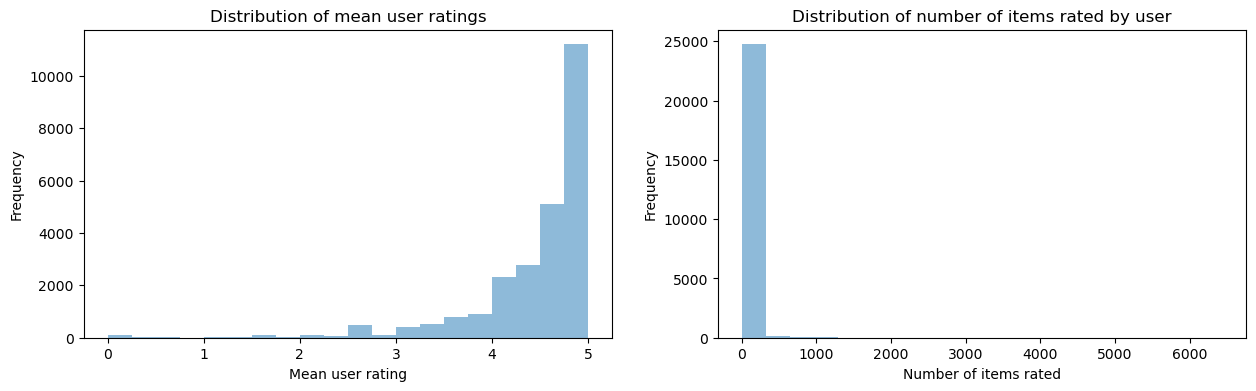

In [400]:
## Compute the mean rating for each of the users in the training dataset
mean_ratings = []
number_ratings = []

for id, ratings in ml_trainset.ur.items():
    m_rating = sum(r for (_, r) in ratings) / len(ratings)
    mean_ratings.append(m_rating)

    # Number of ratings from a user
    n = len(ratings)
    number_ratings.append(n)
    
## Create a histograms of the results
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(mean_ratings, bins=20, alpha=0.5) 
_=ax[0].set_xlabel('Mean user rating')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of mean user ratings')
_=ax[1].hist(number_ratings, bins=20, alpha=0.5) 
_=ax[1].set_xlabel('Number of items rated')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of number of items rated by user')

The distribution of mean user ratings is very skewed. There's a lot of mean ratings that are on the higher end and at the maximum and not nearly as many closer to 0 or in the middle. This skew tells us that the majority of users who tend to rate stuff on the online catalog will tend to rate very  positively (considering the mid point is 2.5). The long tail tells us that there are many users who rate only few items on the catalog. We can take from this user behavior is characterized by a lots of users who don't really often rating items, with a smaller number of users who are more active in rating a larger number of items which we chose not to filter out for maintaining our datasets.

#### Baseline

In [401]:
np.random.seed(864)
## Instantiate the model object and fit to the training data  
baseline_model = BaselineOnly()
baseline_model.fit(ml_trainset)

## Compute the predictions from the model 
predict = baseline_model.test(ml_testset)

# Compute RMSE and MAE
rmse = accuracy.rmse(predict)
mae = accuracy.mae(predict)

print(f"\nRMSE = {rmse}\nMAE = {mae}")

Estimating biases using als...
RMSE: 1.3264
MAE:  0.8364

RMSE = 1.3264435837512984
MAE = 0.8363772292281066


RMSE and MAE are metrics that can be used to evaluate how accurate our regression model's predictions are and how much do its values deviate from our actual values. An RMSE that's that close to 1 can be considered accepatable along with a low MAE - which is what partially have. The RMSE is above 1 but close to it still. Our accuracy performance for this simple model seems acceptable, if lower than we'd like. I'd like to compare it to more sophisticated models to further evaluate it.

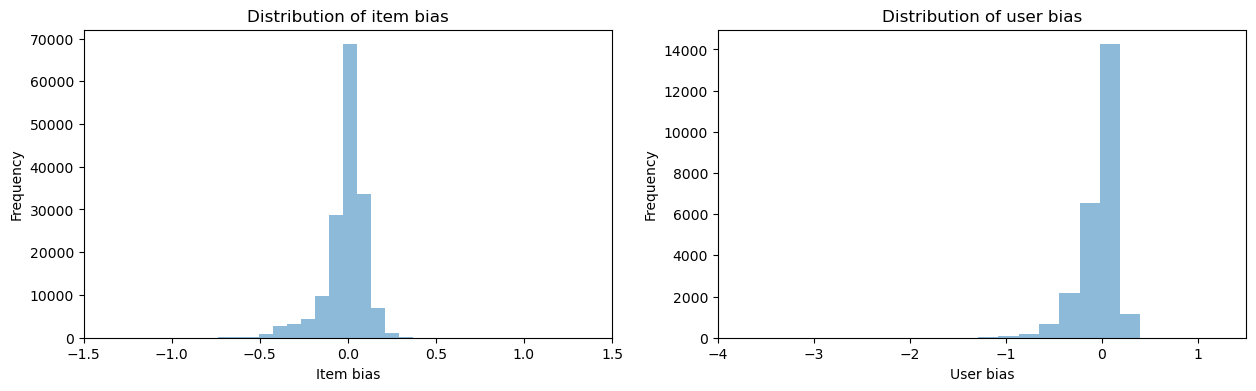

In [402]:
## plot the biases
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(baseline_model.bi, bins=20, alpha=0.5) 
_=ax[0].set_xlabel('Item bias')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of item bias')
_=ax[0].set_xlim(-1.5,1.5)
_=ax[1].hist(baseline_model.bu, bins=20, alpha=0.5) 
_=ax[1].set_xlabel('User bias')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of user bias')
_=ax[1].set_xlim(-4,1.5)

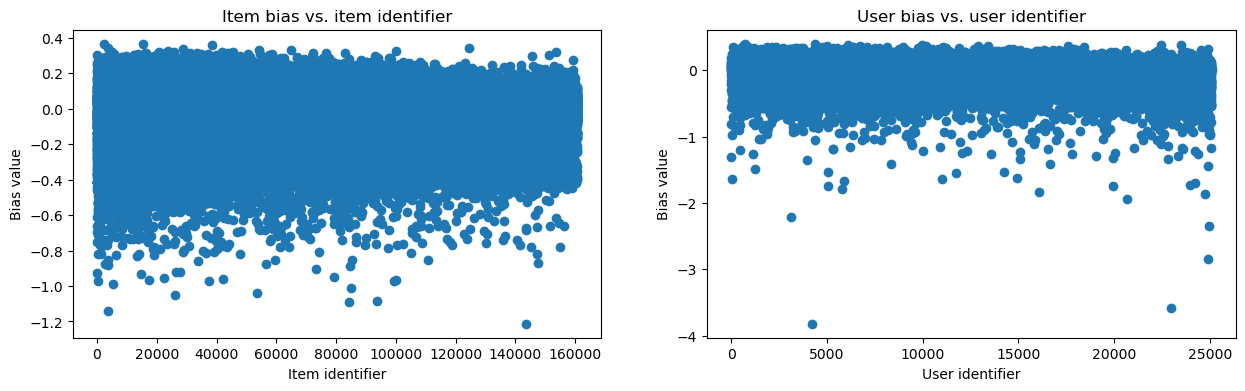

In [403]:
## plot the biases
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].scatter(range(len(baseline_model.bi)), baseline_model.bi) 
_=ax[0].set_xlabel('Item identifier')
_=ax[0].set_ylabel('Bias value')
_=ax[0].set_title('Item bias vs. item identifier')
_=ax[1].scatter(range(len(baseline_model.bu)), baseline_model.bu) 
_=ax[1].set_xlabel('User identifier')
_=ax[1].set_ylabel('Bias value')
_=ax[1].set_title('User bias vs. user identifier')

From what we can see, in both cases, the bias is generally more negatively leaning – there’s heavy tails for both item and user bias. Negative bias is more strongly detected in the case of user bias – we have bias values that reach nearly 4 whereas positive bias generally doesn’t exceed 0.5. 
We can use biases to help adjust the baseline model. However, because these bias values have a large range of values, it suggests to me that that that the biases, especially with the user bias, may be taking a strong role in the prediction process. It appears as well that the bias is not uniformly distributed as the range of bias values favors negative values across the identifiers. The data appears to be heteroskedastic, especially in the case of user biases. 


In [ ]:
#np.random.seed(258)
## Instantiate the model object and fit to the training data  

#collaborative_filter_model = KNNBasic()
#collaborative_filter_model.fit(ml_trainset)

## Compute the predicitons from the model 
#kpred = collaborative_filter_model.test(ml_testset)

# Compute some model performance statistics
#krmse = accuracy.rmse(kpred)
#kmae = accuracy.mae(kpred)

#print(f"\nRMSE = {krmse}\nMAE = {kmae}")


Due to memory error, we are unable to present findings of a surprise package collaborative filtering model based on KMeans. In Jupyter and even Google Colab, the operation failed when using these above parameters.

#### SVD

In [417]:
np.random.seed(9741)
## Instantiate the model object and fit to the training data  
## Put your code here
n_factors=10
svd_model = SVD(n_factors=10)
svd_model.fit(ml_trainset)


## Compute the predicitons from the model 
## Put your code here
svd_pred = svd_model.test(ml_testset)

# Compute some model performance statistics
## Put your code here
svd_r = accuracy.rmse(svd_pred)
svd_m = accuracy.mae(svd_pred)

print(f"\nSVD RMSE = {svd_r}\nSVD MAE = {svd_m}")


RMSE: 1.3126
MAE:  0.8256

SVD RMSE = 1.3126052605244514
SVD MAE = 0.8256333117084851


The RMSE is lower than the baseline model's (1.3126 vs 1.3264) which is actually better in terms of accuracy since it is now closer to 1. The MAE is lower for the SVD model's than the baseline model's (0.8256 vs 0.8364). I would say that since the RMSE and MAE are lower, the SVD model has better performance. It is the difference between the actual value (rating) and the predicted value so it being lower suggests there's less difference between our models' predictions and the actual values - it doing better may suggest it has better performance.

What do these results tell us about the performance of a SVD model vs a baseline model? The lower RMSE and MAE values of the SVD/latent factor recommender model compared to the baseline model suggest that leveraging latent factors can improve predictive performance, even when the dataset is dense. Taking a look at some of the differences in models: baseline models utilize more static parameters when opinions, behaviors, and ratings may change with time. In addition, peoples' opinions may differ in many systematic ways that can't quite be explained entirely by merely data. For example, some regional differences may be something a latent factor recommender can take into account whereas a baseline model might not e.g. ratings for Yankees merch may be inordinately lower for people from Boston or fans of the Red Sox.

Shape of item factor matrix: (160775, 10)
Shape of user factor matrix: (25076, 10)


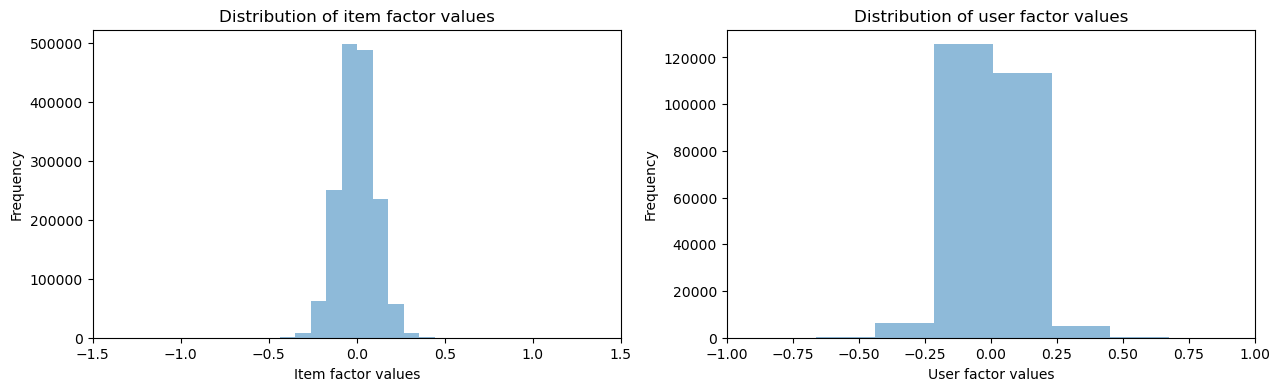

In [429]:
print('Shape of item factor matrix: {}'.format(svd_model.qi.shape))
print('Shape of user factor matrix: {}'.format(svd_model.pu.shape))

## Create a histograms of the factor values
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(svd_model.qi.flatten(), bins=20, alpha=0.5) 
_=ax[0].set_xlabel('Item factor values')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of item factor values')
_=ax[0].set_xlim(-1.50,1.50)
_=ax[1].hist(svd_model.pu.flatten(), bins=20, alpha=0.5) 
_=ax[1].set_xlabel('User factor values')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of user factor values')
_=ax[1].set_xlim(-1.0,1.0)

Taking into the account that the SVD model subtracts the bias terms before computing the factor values, we saw that the SVD model has a narrower distribution compared to the distribution of baseline or bias values for the baseline models. Because we subtracted the bias terms, the resulting factor values are centered around zero and the variability in the factor values is consequently. This results in a narrower range. These differences in the range of values suggest that subtracting bias normalizes factor values and reduces influence of itema and user biases so our model can capture the latent factors that are involved in the structure of the data.

In [419]:
## Calculation of compression of factor model   
n_reviews = 0
for key in ml_trainset.ur.keys(): 
    n_reviews += len(ml_trainset.ur[key])
print(f"Total number of reviews = {n_reviews}")
utility_bytes = 8*n_reviews + 4*ml_trainset.n_users
print(f"Bytes for all review tuples = {utility_bytes}")

P_size = n_factors * ml_trainset.n_users
Q_size = n_factors * ml_trainset.n_items
print(f"Values in P = {P_size}")
print(f"Values in Q = {Q_size}")
PQ_bytes = 4 * (P_size + Q_size)
print(f"Total bytes for P + Q = {PQ_bytes}")

Total number of reviews = 697924
Bytes for all review tuples = 5683696
Values in P = 250760
Values in Q = 1607750
Total bytes for P + Q = 7434040


Taking a look at the compression of the factor model:

The training data utilized had 25076 users and 160775 items. When calculating the number of possible pairs, we got 4031593900. Compared to the number of pairs, the total number of bytes is 7434040 while dimensions are 10 latent factors x users or items. We decomposed the original utility matrix into two matrices Q and P which occupy a lot less memory than the original data. The factor matrices require memory proportional to the number of latent factors multiplied by the number of users/items (which is much smaller than the original dataset). This reduction in storage requirements makes the representation more compact/less dense thant the original data set. With fewer dimensions to consider, computations become a lot less intensive and less complex. Ultimately, the representation is compact compared to the original data.